In [1]:
import numpy as np
import pandas as pd
import pickle
from matplotlib import pyplot as plt
from esem.utils import plot_results, prettify_plot, add_121_line, leave_one_out
from esem import rf_model
from sklearn.metrics import mean_squared_error
from scipy import stats

import warnings
from sklearn.exceptions import DataConversionWarning
warnings.filterwarnings(action='ignore', category=DataConversionWarning)

2022-02-22 14:35:44.175039: W tensorflow/stream_executor/platform/default/dso_loader.cc:64] Could not load dynamic library 'libcudart.so.11.0'; dlerror: libcudart.so.11.0: cannot open shared object file: No such file or directory
2022-02-22 14:35:44.175081: I tensorflow/stream_executor/cuda/cudart_stub.cc:29] Ignore above cudart dlerror if you do not have a GPU set up on your machine.


# Load dataset

In [2]:
train = np.loadtxt("train.txt")
Y = train[:, 0]
X = train[:, 1:]
print(Y.shape)
print(X.shape)

(640122,)
(640122, 5)


In [3]:
# Define training and test inds
n_train = int(Y.shape[0] * 0.8) # 80 % training
training_inds = np.arange(0, n_train)
testing_inds = np.arange(n_train, len(Y))
n_test = len(testing_inds)

print(n_train)
print(n_test)

512097
128025


# Define training data set

In [4]:
X_train = X[training_inds, :]
Y_train = Y[training_inds]

# Train model

In [5]:
%%time
rf_model = rf_model(X_train, Y_train)
rf_model.train()

2022-02-22 14:37:34.501112: W tensorflow/stream_executor/platform/default/dso_loader.cc:64] Could not load dynamic library 'libcuda.so.1'; dlerror: libcuda.so.1: cannot open shared object file: No such file or directory
2022-02-22 14:37:34.501158: W tensorflow/stream_executor/cuda/cuda_driver.cc:269] failed call to cuInit: UNKNOWN ERROR (303)
2022-02-22 14:37:34.501192: I tensorflow/stream_executor/cuda/cuda_diagnostics.cc:156] kernel driver does not appear to be running on this host (shas0255.rc.int.colorado.edu): /proc/driver/nvidia/version does not exist
2022-02-22 14:37:34.501784: I tensorflow/core/platform/cpu_feature_guard.cc:151] This TensorFlow binary is optimized with oneAPI Deep Neural Network Library (oneDNN) to use the following CPU instructions in performance-critical operations:  AVX2 FMA
To enable them in other operations, rebuild TensorFlow with the appropriate compiler flags.


CPU times: user 4min 57s, sys: 2.95 s, total: 4min 59s
Wall time: 5min 10s


# Define testing data set

In [6]:
X_test = X[testing_inds, :]

# Inference

In [7]:
%%time
Y_rf_test = rf_model.predict(X_test)[0]

CPU times: user 10.6 s, sys: 3.02 s, total: 13.6 s
Wall time: 14.9 s


In [8]:
# %%time
# Y_gp_test = gp_model.predict(X_test)[0]

# Perform analysis

In [9]:
x_1_to_1 = [-9999, 9999]
y_1_to_1 = [-9999, 9999]

In [10]:
def calc_rmse(predictions, targets):
    return np.sqrt(((predictions - targets) ** 2).mean())

def calc_bias(predictions, targets):
    return (predictions - targets).mean()

60.875595465290644
52.126884160304854


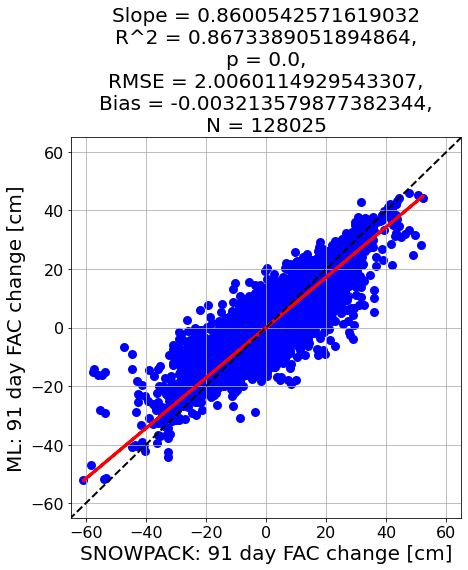

In [18]:
# Random Forest 
x = Y[testing_inds] * 100 # Truth (cm)
y = Y_rf_test * 100 # Prediction (cm)
lin_reg = stats.linregress(x, y)
rmse = calc_rmse(y, x)
bias = calc_bias(y, x)


plt.figure(figsize=(7, 7))
plt.scatter(x, y, c='b', linewidth=3)
plt.plot(x, lin_reg.intercept + lin_reg.slope*x, 'r', label='fitted line', linewidth=3)
plt.plot(x_1_to_1, y_1_to_1, 'k--', linewidth=2)
plt.xlim([-65, 65])
plt.ylim([-65, 65])
plt.grid()
plt.xlabel("SNOWPACK: 91 day FAC change [cm]", fontsize=20)
plt.ylabel("ML: 91 day FAC change [cm]", fontsize=20)
plt.xticks(fontsize=16)
plt.yticks(fontsize=16)
plt.title("Slope = " + str(lin_reg.slope) + \
          "\nR^2 = " + str(lin_reg.rvalue**2) + \
          ",\np = " + str(lin_reg.pvalue) + \
          ",\nRMSE = " + str(rmse) + \
          ",\nBias = " + str(bias) + \
          ",\nN = " + str(n_test),
         fontsize=20)

# Print max and min for axis limits determination
print(np.abs(x).max())
print(np.abs(y).max())

42.99519001907876


(array([    0., 10000., 20000., 30000., 40000., 50000., 60000., 70000.]),
 [Text(0, 0, ''),
  Text(0, 0, ''),
  Text(0, 0, ''),
  Text(0, 0, ''),
  Text(0, 0, ''),
  Text(0, 0, ''),
  Text(0, 0, ''),
  Text(0, 0, '')])

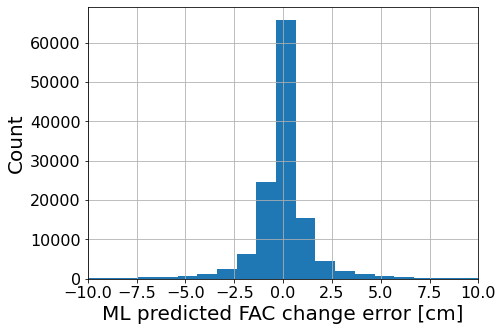

In [19]:
diff = y - x
limit = np.abs(diff).max()
print(limit)

# Histogram
plt.figure(figsize=(7, 5))
plt.hist(diff, bins=75)
plt.grid()
# plt.xlim([-limit, limit])
plt.xlim([-10, 10])
plt.xlabel("ML predicted FAC change error [cm]", fontsize=20)
plt.ylabel("Count", fontsize=20)
plt.xticks(fontsize=16)
plt.yticks(fontsize=16)

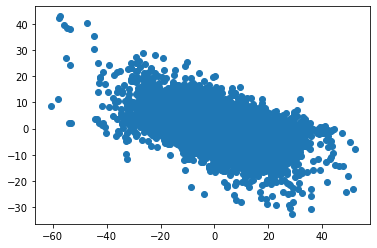

In [21]:
plt.scatter(x, diff)

In [22]:
diff.max()

42.99519001907876